In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [2]:
train_directory = '../input/fer2013/train/'
test_directory = '../input/fer2013/test/'

image_rows, image_cols = 48, 48
num_classes = 7

def count_images(directory, set_type):
    count_dict = {}
    for expression in os.listdir(directory):
        expression_dir = directory + expression
        count_dict[expression] = len(os.listdir(expression_dir))
    df = pd.DataFrame(count_dict, index=[set_type])
    return df

train_counts = count_images(train_directory, 'train')
test_counts = count_images(test_directory, 'test')


In [3]:
train_datagenarate = ImageDataGenerator(rescale=1./255,zoom_range=0.3,horizontal_flip=True)

training_set = train_datagenarate.flow_from_directory(train_directory,batch_size=64,target_size=(48,48),shuffle=True,color_mode='grayscale',class_mode='categorical')

test_datagenarate = ImageDataGenerator(rescale=1./255)
test_set = test_datagenarate.flow_from_directory(test_directory,batch_size=64,target_size=(48,48),shuffle=True, color_mode='grayscale',class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
class_indices = training_set.class_indices
class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [5]:
def create_model(input_shape, num_classes=7):
    
    cnn_model = tf.keras.models.Sequential()

    cnn_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(2, 2))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(1024, activation='relu'))
    cnn_model.add(Dropout(0.5))

    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

    return cnn_model


In [7]:
from tensorflow.keras.optimizers.legacy import Adam

fernet = create_model((image_rows,image_cols,1), num_classes)
fernet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,validation_data=test_set,epochs=60,callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/60


2023-04-06 17:09:57.929463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - ETA: 0s - loss: 4.2217 - accuracy: 0.2849
Epoch 1: val_loss improved from inf to 6.23069, saving model to ferNet.h5
448/448 [==============================] - 218s 473ms/step - loss: 4.2217 - accuracy: 0.2849 - val_loss: 6.2307 - val_accuracy: 0.0968 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.4353 - accuracy: 0.3360
Epoch 2: val_loss improved from 6.23069 to 3.03527, saving model to ferNet.h5
448/448 [==============================] - 48s 106ms/step - loss: 3.4353 - accuracy: 0.3360 - val_loss: 3.0353 - val_accuracy: 0.4064 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.9058 - accuracy: 0.3753
Epoch 3: val_loss improved from 3.03527 to 2.58616, saving model to ferNet.h5
448/448 [==============================] - 47s 105ms/step - loss: 2.9058 - accuracy: 0.3753 - val_loss: 2.5862 - val_accuracy: 0.4326 - lr: 1.0000e-04
Epoch 4/60
448/448 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



448/448 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.7713
Epoch 34: val_loss did not improve from 1.10119
448/448 [==============================] - 45s 101ms/step - loss: 0.7221 - accuracy: 0.7713 - val_loss: 1.1024 - val_accuracy: 0.6574 - lr: 2.0000e-05
Epoch 35/60
448/448 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7729
Epoch 35: val_loss did not improve from 1.10119
448/448 [==============================] - 47s 105ms/step - loss: 0.7123 - accuracy: 0.7729 - val_loss: 1.1156 - val_accuracy: 0.6602 - lr: 2.0000e-05
Epoch 36/60
448/448 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.7754
Epoch 36: val_loss did not improve from 1.10119
448/448 [==============================] - 46s 104ms/step - loss: 0.7017 - accuracy: 0.7754 - val_loss: 1.1271 - val_accuracy: 0.6604 - lr: 2.0000e-05
Epoch 37/60
448/448 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.7789
Epoch 37: val_loss did not 

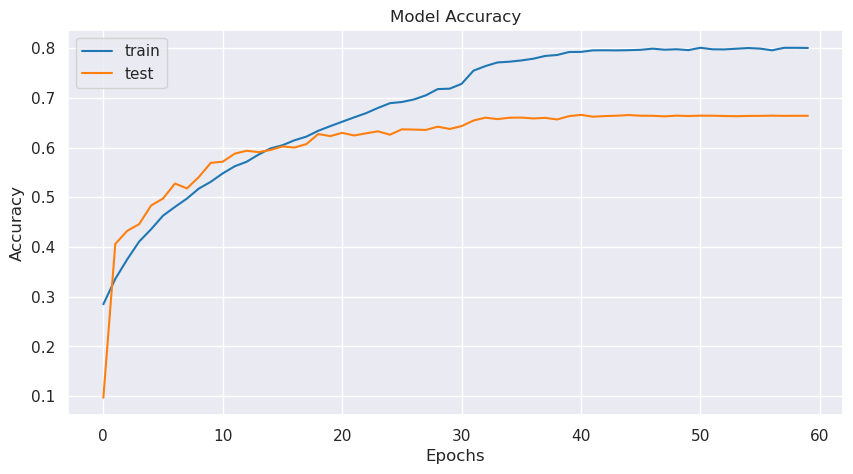

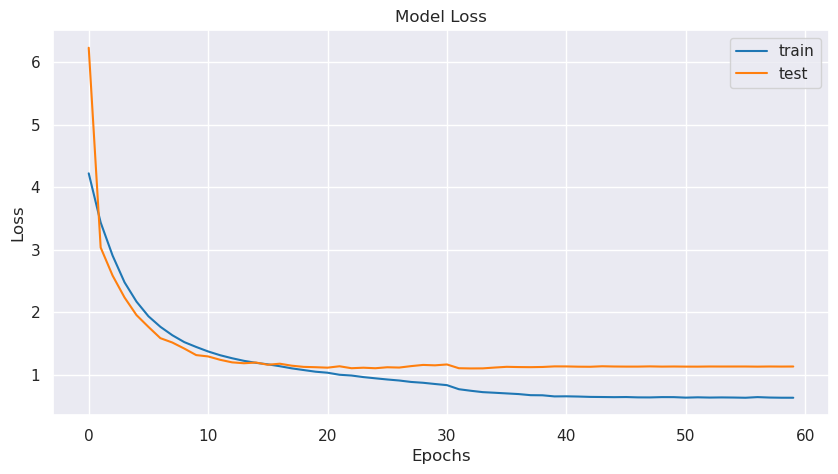

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the accuracy and loss values from the history object
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a Seaborn line plot for accuracy
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(accuracy)), y=accuracy, label='train')
sns.lineplot(x=range(len(val_accuracy)), y=val_accuracy, label='test')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Create a Seaborn line plot for loss
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(loss)), y=loss, label='train')
sns.lineplot(x=range(len(val_loss)), y=val_loss, label='test')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()


In [20]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)

train_accu_pct = train_accu * 100
test_accu_pct = test_accu * 100

print(f"Final train accuracy = {train_accu_pct:.2f}%, validation accuracy = {test_accu_pct:.2f}%")


113/113 [==============================] - 7s 61ms/step - loss: 1.1317 - accuracy: 0.6643
Final train accuracy = 87.46%, validation accuracy = 66.43%


In [21]:
fernet.save_weights('fernet_bestweight.h5')

449/449 [==============================] - 37s 83ms/step
Confusion Matrix
[[ 497   52  520 1048  727  714  437]
 [  60    6   71  115   80   65   39]
 [ 589   51  520 1050  765  673  449]
 [ 969   90  896 1866 1326 1257  811]
 [ 671   68  657 1229  899  853  588]
 [ 642   67  600 1255  900  833  533]
 [ 435   44  415  829  551  556  341]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.12      0.13      3995
     disgust       0.02      0.01      0.01       436
        fear       0.14      0.13      0.13      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



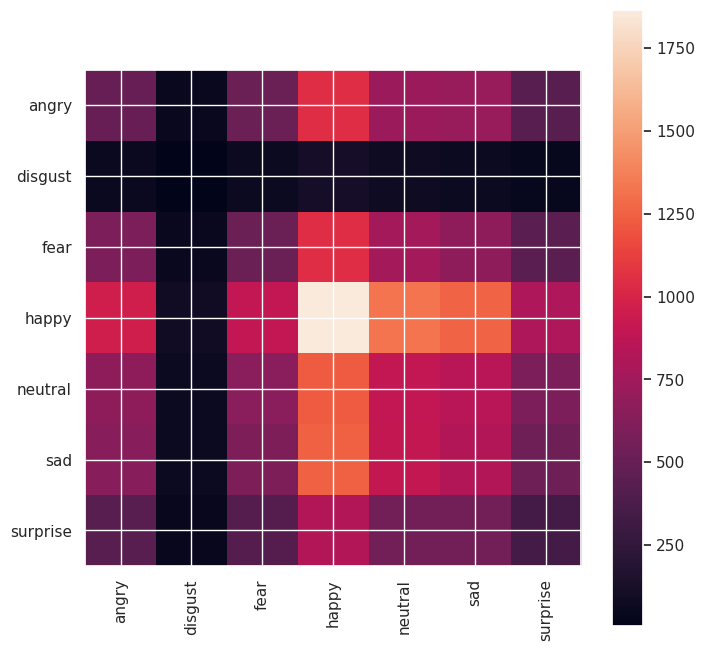

In [22]:
# Make predictions on the training set and convert to class labels
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)

# Get the class labels from the test set and invert the mapping to create a dictionary
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

# Compute the confusion matrix and classification report for the training set
from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

# Plot the confusion matrix as an image
plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(target_names))
_ = plt.xticks(tick_marks, target_names, rotation=90)
_ = plt.yticks(tick_marks, target_names)


113/113 [==============================] - 7s 60ms/step
Confusion Matrix
[[138   9 129 238 170 168 106]
 [ 14   3  15  22  24  22  11]
 [145   6 103 268 213 172 117]
 [242  16 219 444 340 301 212]
 [185  10 147 290 254 207 140]
 [181  13 128 300 251 225 149]
 [131   4  91 218 157 123 107]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       958
     disgust       0.05      0.03      0.03       111
        fear       0.12      0.10      0.11      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.18      0.21      0.19      1233
         sad       0.18      0.18      0.18      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



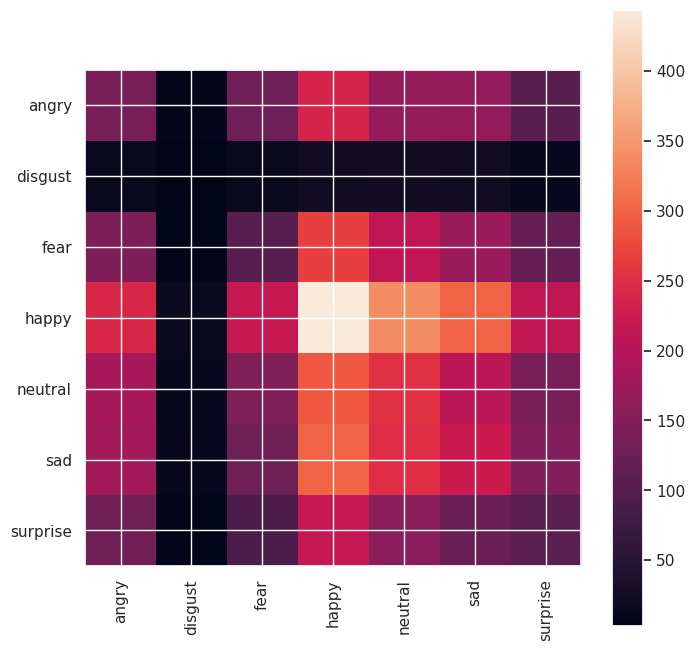

In [23]:
# Make predictions on the test set and convert to class labels
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

# Get the class labels from the test set and invert the mapping to create a dictionary
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

# Compute the confusion matrix and classification report for the test set
from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

# Plot the confusion matrix as an image
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(target_names))
_ = plt.xticks(tick_marks, target_names, rotation=90)
_ = plt.yticks(tick_marks, target_names)


In [25]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Load the trained model from Kaggle
model_path = '/kaggle/working/ferNet.h5'
model = keras.models.load_model(model_path)

# Define the emotions that the model can detect
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Start capturing video from the camera
cap = cv2.VideoCapture(0)

# Set the font and font scale for displaying text on the screen
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 2

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame using Haar cascades
    face_cascade = cv2.CascadeClassifier('/kaggle/input/haarcascade-frontalface-defaultxml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # For each detected face, predict the emotion using the trained model and draw a rectangle around the face
    for (x, y, w, h) in faces:
        face_gray = gray[y:y+h, x:x+w]
        face_gray = cv2.resize(face_gray, (48, 48))
        face_gray = np.reshape(face_gray, [1, 48, 48, 1])
        prediction = model.predict(face_gray)
        emotion = emotions[np.argmax(prediction)]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion, (x, y), font, font_scale, (0, 255, 0), font_thickness, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('Emotion Detector', frame)

    # Quit the program if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()


[ WARN:0] global /tmp/pip-req-build-jpmv6t9_/opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
